# Handling duplicate breakpoints

> ⚠️ This notebook is not finished. It still needs some research/feedback to
> determine if it's worth it to look further into it.

The paper states the following as a last remark:

The area (positive or negative) contributed to the integral by the piece $(u_1,
u_2)$ is easy to write as a weight term: $area(u_1, u_2) =
\frac{1}{2}(break_y(u_1) + break_y(u_2))(break_x(u_2) - break_x(u_1))$. We sum
these to obtain the desired integral. However, since different neurons may
represent the same breakpoint, we must divide by the number of duplicates.
Hence, our desired term $t$ equals

$$
\Sigma_{u_1,u_2:succ(u_1,u_2)}area(u_1,u_2)/(\Sigma_{u'_1,u'_2:\gamma}1)
$$

Where $\gamma$ is the formula $succ(u'_1,u'2) \land break_x(u'_1) = break_x(u_1)
\land break_x(u'_2) = break_x(u_2)$

The integral query from the [previous
chapter](3.2%20Integral%20-%20duplicate%20breakpoints.ipynb) does not handle
this edge case explicitly. In this chapter, we'll dive deeper into the issue of
duplicate breakpoints.

## Creating a reference network

Let's create an artificial neural network where we know for sure that we have
duplicate breakpoints, and test that we account for this.

We start with some preliminary imports.

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import utils.duckdb as db

torch.manual_seed(5)

We'll train our neural network on the same function as the [integral
example](3.1%20Integral.ipynb).

In [27]:
def f(x):
    if x < 0:
        return 0
    elif 0 <= x < 5:
        return x
    elif 5 <= x < 10:
        return 10-x
    else:
        return 0

x_train = np.linspace(-5, 15, 1000)
y_train = np.array([f(x) for x in x_train])

We manually construct a simple network with 4 hidden neurons in one layer and
train it.

In [28]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # 1 input, 4 hidden neurons, 1 output.
        self.hidden = nn.Linear(1, 4)
        self.activation = nn.ReLU()
        self.output = nn.Linear(4, 1)

    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        return x

model = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

Now we'll cheat a bit and make sure that we have a useless neuron by setting the
weights and biases of the first two neurons to be identical.

In [29]:
with torch.no_grad():
    # Set the weights and biases of the first two neurons to be the same
    model.hidden.weight[1] = model.hidden.weight[0]
    model.hidden.bias[1] = model.hidden.bias[0]

Let's plot our neural network:

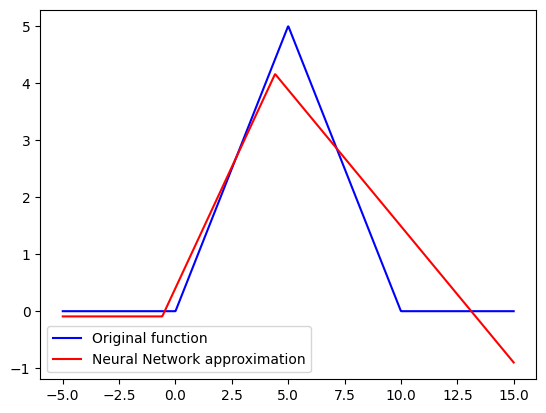

In [30]:
model.eval()
with torch.no_grad():
    predicted = model(x_train_tensor).detach().numpy()

plt.plot(x_train, y_train, 'b', label='Original function')
plt.plot(x_train, predicted, 'r', label='Neural Network approximation')
plt.legend()
plt.show()

Adjusting the neurons obviously alters the network's behavior. We no longer
match the original function, but that's okay for our purposes.

Now let's do a sanity check and see if we can indeed find two identical
breakpoints using the formula $break_x = \frac{-b}{w}$.

In [31]:
# Let's find breakpoints in python for convenience.

weights = model.state_dict()['hidden.weight'].tolist()
biases = model.state_dict()['hidden.bias'].tolist()

break_xs = set()
for i, w in enumerate(weights):
    w = w[0]
    if w == 0:
        continue

    b = biases[i]
    break_x = (-b / w)

    if break_x in break_xs:
        print(f"Found duplicate breakpoint at x={break_x}")
        break

    break_xs.add(break_x)


Found duplicate breakpoint at x=4.417138076614796


We can find our duplicate breakpoint, so everything is looking good so far.
Let's insert the model into our database and continue with our SQL queries.

In [32]:
db.load_pytorch_model_into_db(model)

This is the version with no duplicate checking:

In [33]:
db.con.execute("""
WITH input_node AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (SELECT dst FROM edge)
),
output_node AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (SELECT src FROM edge)
),
hidden_nodes AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (
        SELECT * FROM input_node
        UNION
        SELECT * FROM output_node
    )
),
break_x AS (
    SELECT
        n.id,
        (-n.bias) / e.weight AS break_x, -- -b(u) / w(in1, u)
        ROW_NUMBER() OVER (ORDER BY (-n.bias) / e.weight) AS row_number
    FROM node n
    JOIN edge e ON e.dst = n.id
    JOIN input_node i ON e.src = i.id
    JOIN hidden_nodes h ON h.id = n.id
    WHERE e.weight <> 0
    ORDER BY break_x
),
vals AS (
    SELECT break_x AS val FROM break_x
),
weight_times_input_value AS (
    SELECT
        SUM(e.weight * v.val) AS weight_times_value,
        e.dst AS id,
        v.val AS input_value
    FROM edge e
    JOIN input_node i ON i.id = e.src
    CROSS JOIN vals v
    GROUP BY e.dst, v.val
),
t1 AS (
    SELECT
        GREATEST(weight_times_value + n.bias, 0) AS t1_value,
        input_value,
        n.id
    FROM node n
    JOIN weight_times_input_value i ON i.id = n.id
),
t1_sums AS (
    SELECT
        SUM(
            e.weight *
            t1.t1_value
        ) AS sum,
        t1.input_value,
        e.dst
    FROM edge e
    JOIN t1 ON t1.id = e.src
    GROUP BY t1.input_value, e.dst
),
eval AS (
    SELECT
        t.input_value,
        n.bias + t.sum AS final_output
    FROM node n
    JOIN t1_sums t ON t.dst = n.id
    JOIN output_node o ON o.id = n.id
),
breaks AS (
    SELECT
        u1.break_x AS u1_break_x,
        u2.break_x AS u2_break_x,
        e1.final_output AS u1_break_y,
        e2.final_output AS u2_break_y
    FROM break_x u1
    JOIN break_x u2 ON u1.row_number = u2.row_number - 1
    JOIN eval e1 ON u1.break_x = e1.input_value
    JOIN eval e2 ON u2.break_x = e2.input_value
),
areas AS (
    SELECT
        0.5 * (u1_break_y + u2_break_y) * (u2_break_x - u1_break_x) AS area
    FROM breaks
)

SELECT SUM(area) AS integral FROM areas

""")

area = db.con.fetchone()[0]
print(f"The area of the NN's output function is {area}")

The area of the NN's output function is 4.9260332734153955


Compared to the one with duplicate checking:

In [35]:
with open('queries/integral.sql', 'r') as query_file:
    query = query_file.read()

db.con.sql(query)

┌────────────────────┐
│      integral      │
│       double       │
├────────────────────┤
│ 4.9260332734153955 │
└────────────────────┘